In [1]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [2]:
def get_lag_llama_predictions(dataset, prediction_length, device, context_length=32, use_rope_scaling=False, num_samples=100):
    ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location=device) # Uses GPU since in this Colab we use a GPU.
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="./lag-llama-model/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length, # Lag-Llama was trained with a context length of 32, but can work with any context length

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

In [3]:
import pandas as pd
from gluonts.dataset.pandas import PandasDataset

url = (
    "https://gist.githubusercontent.com/rsnirwan/a8b424085c9f44ef2598da74ce43e7a3"
    "/raw/b6fdef21fe1f654787fa0493846c546b7f9c4df2/ts_long.csv"
)
df = pd.read_csv(url, index_col=0, parse_dates=True)
df

,target,item_id
2021-01-01 00:00:00,-1.3378,A
2021-01-01 01:00:00,-1.6111,A
2021-01-01 02:00:00,-1.9259,A
2021-01-01 03:00:00,-1.9184,A
2021-01-01 04:00:00,-1.9168,A
...,...,...
2021-01-10 19:00:00,1.2349,J
2021-01-10 20:00:00,1.1525,J
2021-01-10 21:00:00,1.1485,J
2021-01-10 22:00:00,1.3248,J


In [4]:
# Set numerical columns as float32
for col in df.columns:
    # Check if column is not of string type
    if df[col].dtype != 'object' and pd.api.types.is_string_dtype(df[col]) == False:
        df[col] = df[col].astype('float32')

# Create the Pandas
dataset = PandasDataset.from_long_dataframe(df, target="target", item_id="item_id")

backtest_dataset = dataset
prediction_length = 24  # Define your prediction length. We use 24 here since the data is of hourly frequency
num_samples = 100 # number of samples sampled from the probability distribution for each timestep
device = torch.device("cuda:0") # You can switch this to CPU or other GPUs if you'd like, depending on your environment

In [5]:
forecasts, tss = get_lag_llama_predictions(backtest_dataset, prediction_length, device, num_samples)

/tmp/ipykernel_192536/42396323.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location=device) # Uses GPU sinc

In [6]:
len(forecasts)

10

In [7]:
forecasts[0].samples.shape

(100, 24)

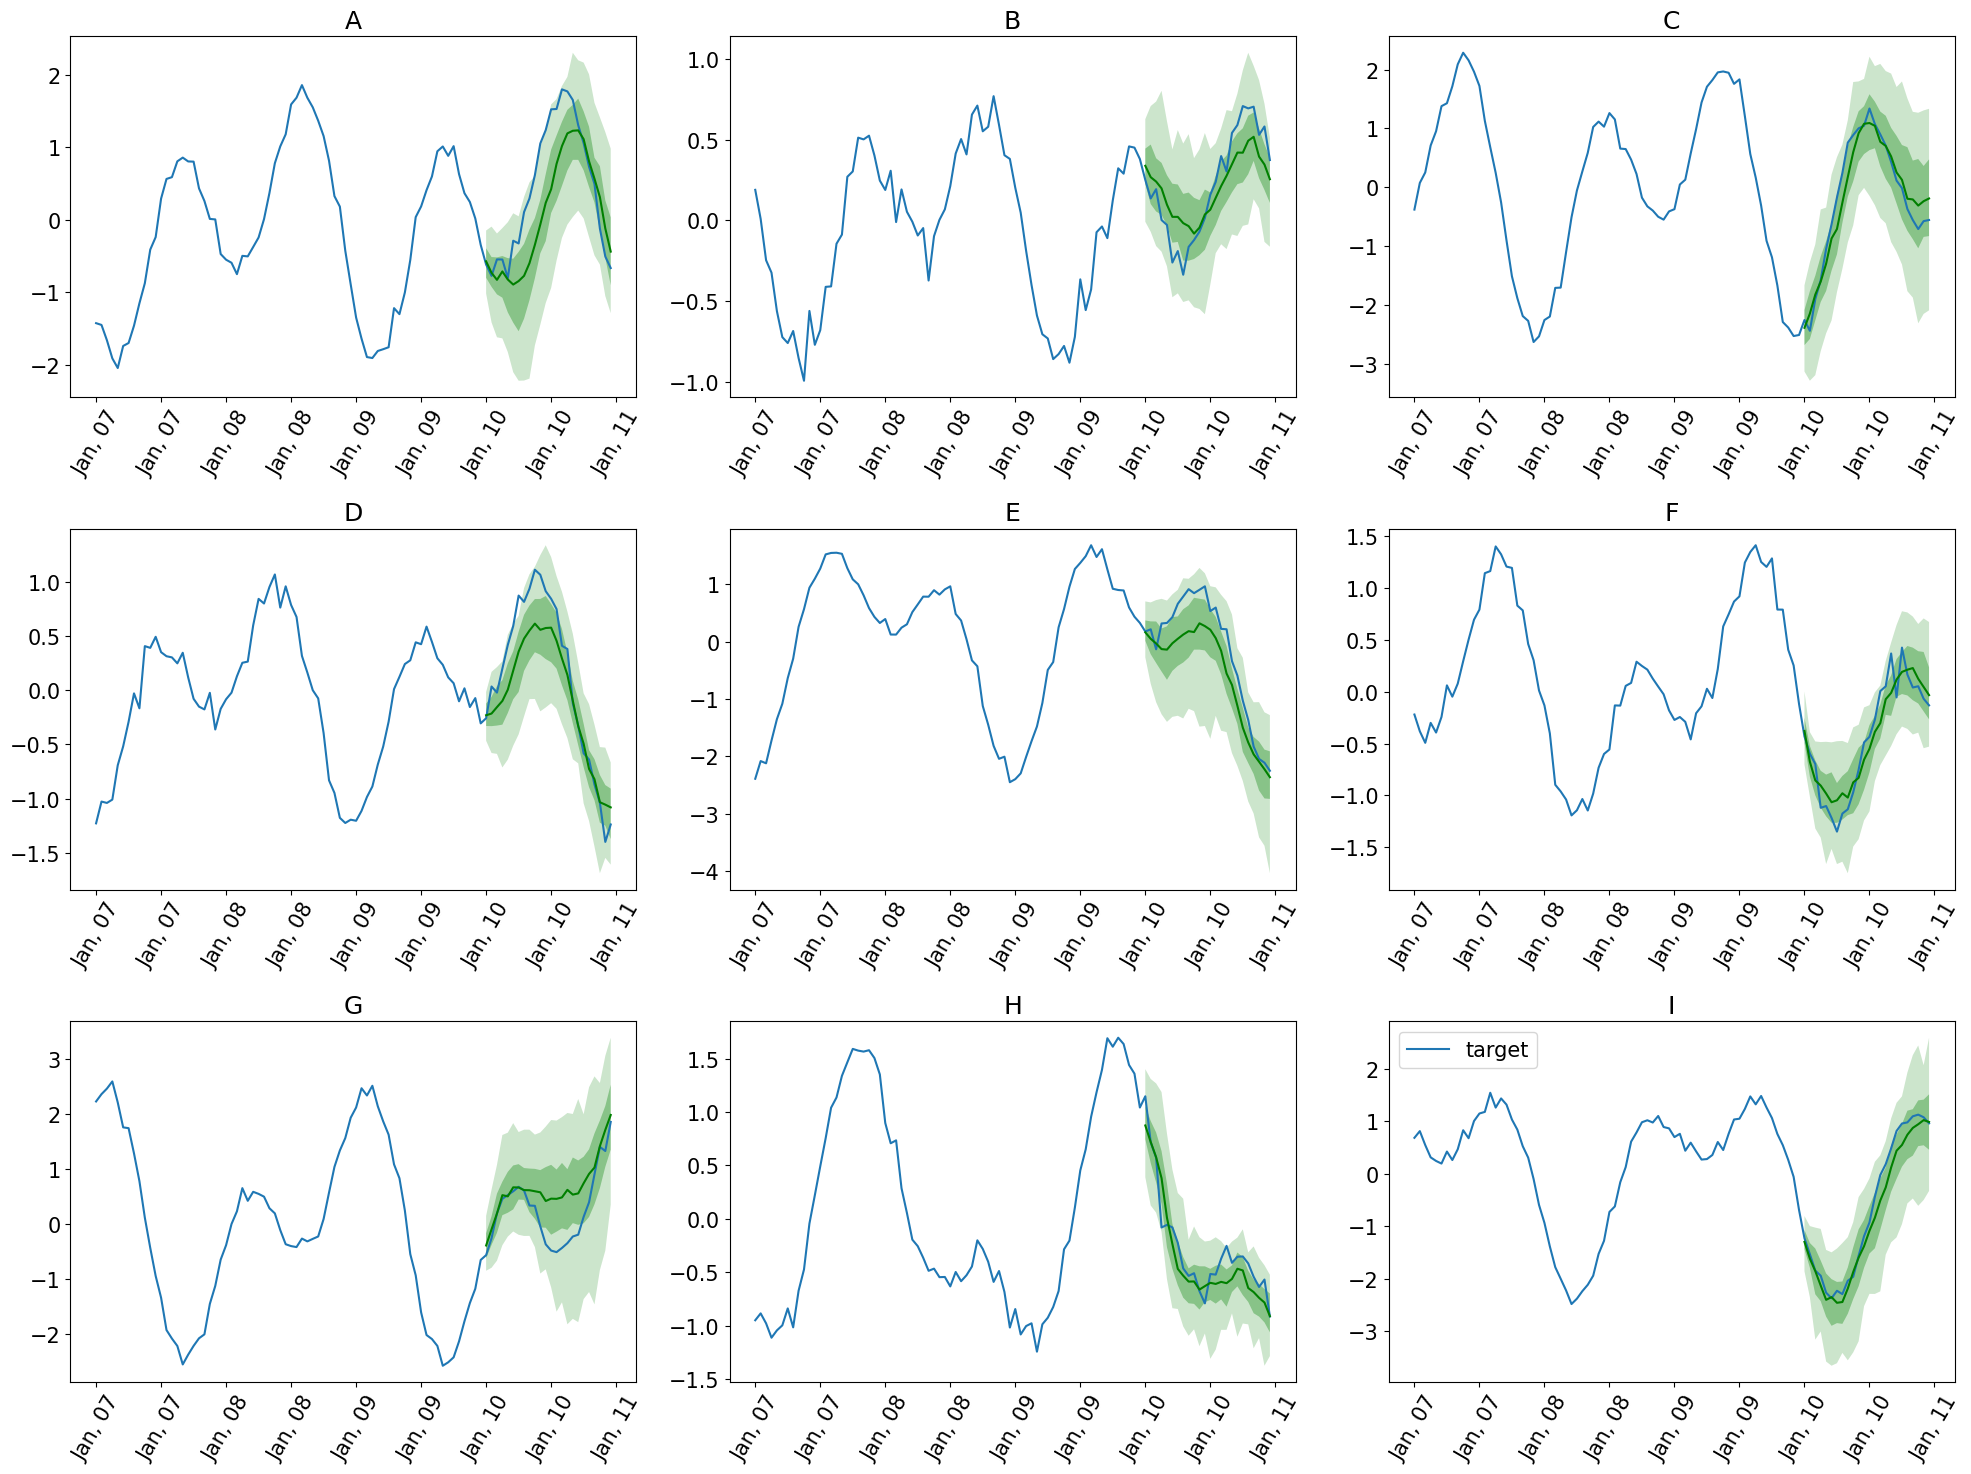

In [8]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [9]:
import pandas as pd
import numpy as np
from gluonts.dataset.pandas import PandasDataset

url = (
    "https://gist.githubusercontent.com/rsnirwan/a8b424085c9f44ef2598da74ce43e7a3"
    "/raw/b6fdef21fe1f654787fa0493846c546b7f9c4df2/ts_long.csv"
)
df = pd.read_csv(url, index_col=0, parse_dates=True)
remove_ind = np.random.choice(np.arange(df.shape[0]), size=100, replace=False)
mask = [False if i in remove_ind else True for i in range(df.shape[0])]
df_missing_val = df.loc[mask, :]  # dataframe with 100 rows removed from df
df

,target,item_id
2021-01-01 00:00:00,-1.3378,A
2021-01-01 01:00:00,-1.6111,A
2021-01-01 02:00:00,-1.9259,A
2021-01-01 03:00:00,-1.9184,A
2021-01-01 04:00:00,-1.9168,A
...,...,...
2021-01-10 19:00:00,1.2349,J
2021-01-10 20:00:00,1.1525,J
2021-01-10 21:00:00,1.1485,J
2021-01-10 22:00:00,1.3248,J


In [10]:
# Get the max end date
max_end = max(df.groupby("item_id").apply(lambda _df: _df.index[-1]))
dfs_dict = {}
for item_id, gdf in df_missing_val.groupby("item_id"):
    # Get the full (regular) date range
    new_index = pd.date_range(gdf.index[0], end=max_end, freq="1H")
    # Reindex the dataframe
    dfs_dict[item_id] = gdf.reindex(new_index).drop("item_id", axis=1)
    # Conver the columns to float32 for lag-llama
    for col in dfs_dict[item_id]:
        # Check if column is not of string type
        if dfs_dict[item_id][col].dtype != 'object' and pd.api.types.is_string_dtype(dfs_dict[item_id][col]) == False:
            dfs_dict[item_id][col] = dfs_dict[item_id][col].astype('float32')

# Create a PandasDataset
ds = PandasDataset(dfs_dict, target="target")

In [11]:
backtest_dataset = ds
prediction_length = 24  # Define your prediction length. We use 24 here since the data is of hourly frequency
num_samples = 100 # number of samples sampled from the probability distribution for each timestep
device = torch.device("cuda:0") # You can switch this to CPU or other GPUs if you'd like, depending on your environment

In [12]:
forecasts, tss = get_lag_llama_predictions(backtest_dataset, prediction_length, device, num_samples)

/tmp/ipykernel_192536/42396323.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location=device) # Uses GPU sinc

In [13]:
len(forecasts)

10

In [14]:
forecasts[0].samples.shape

(100, 24)

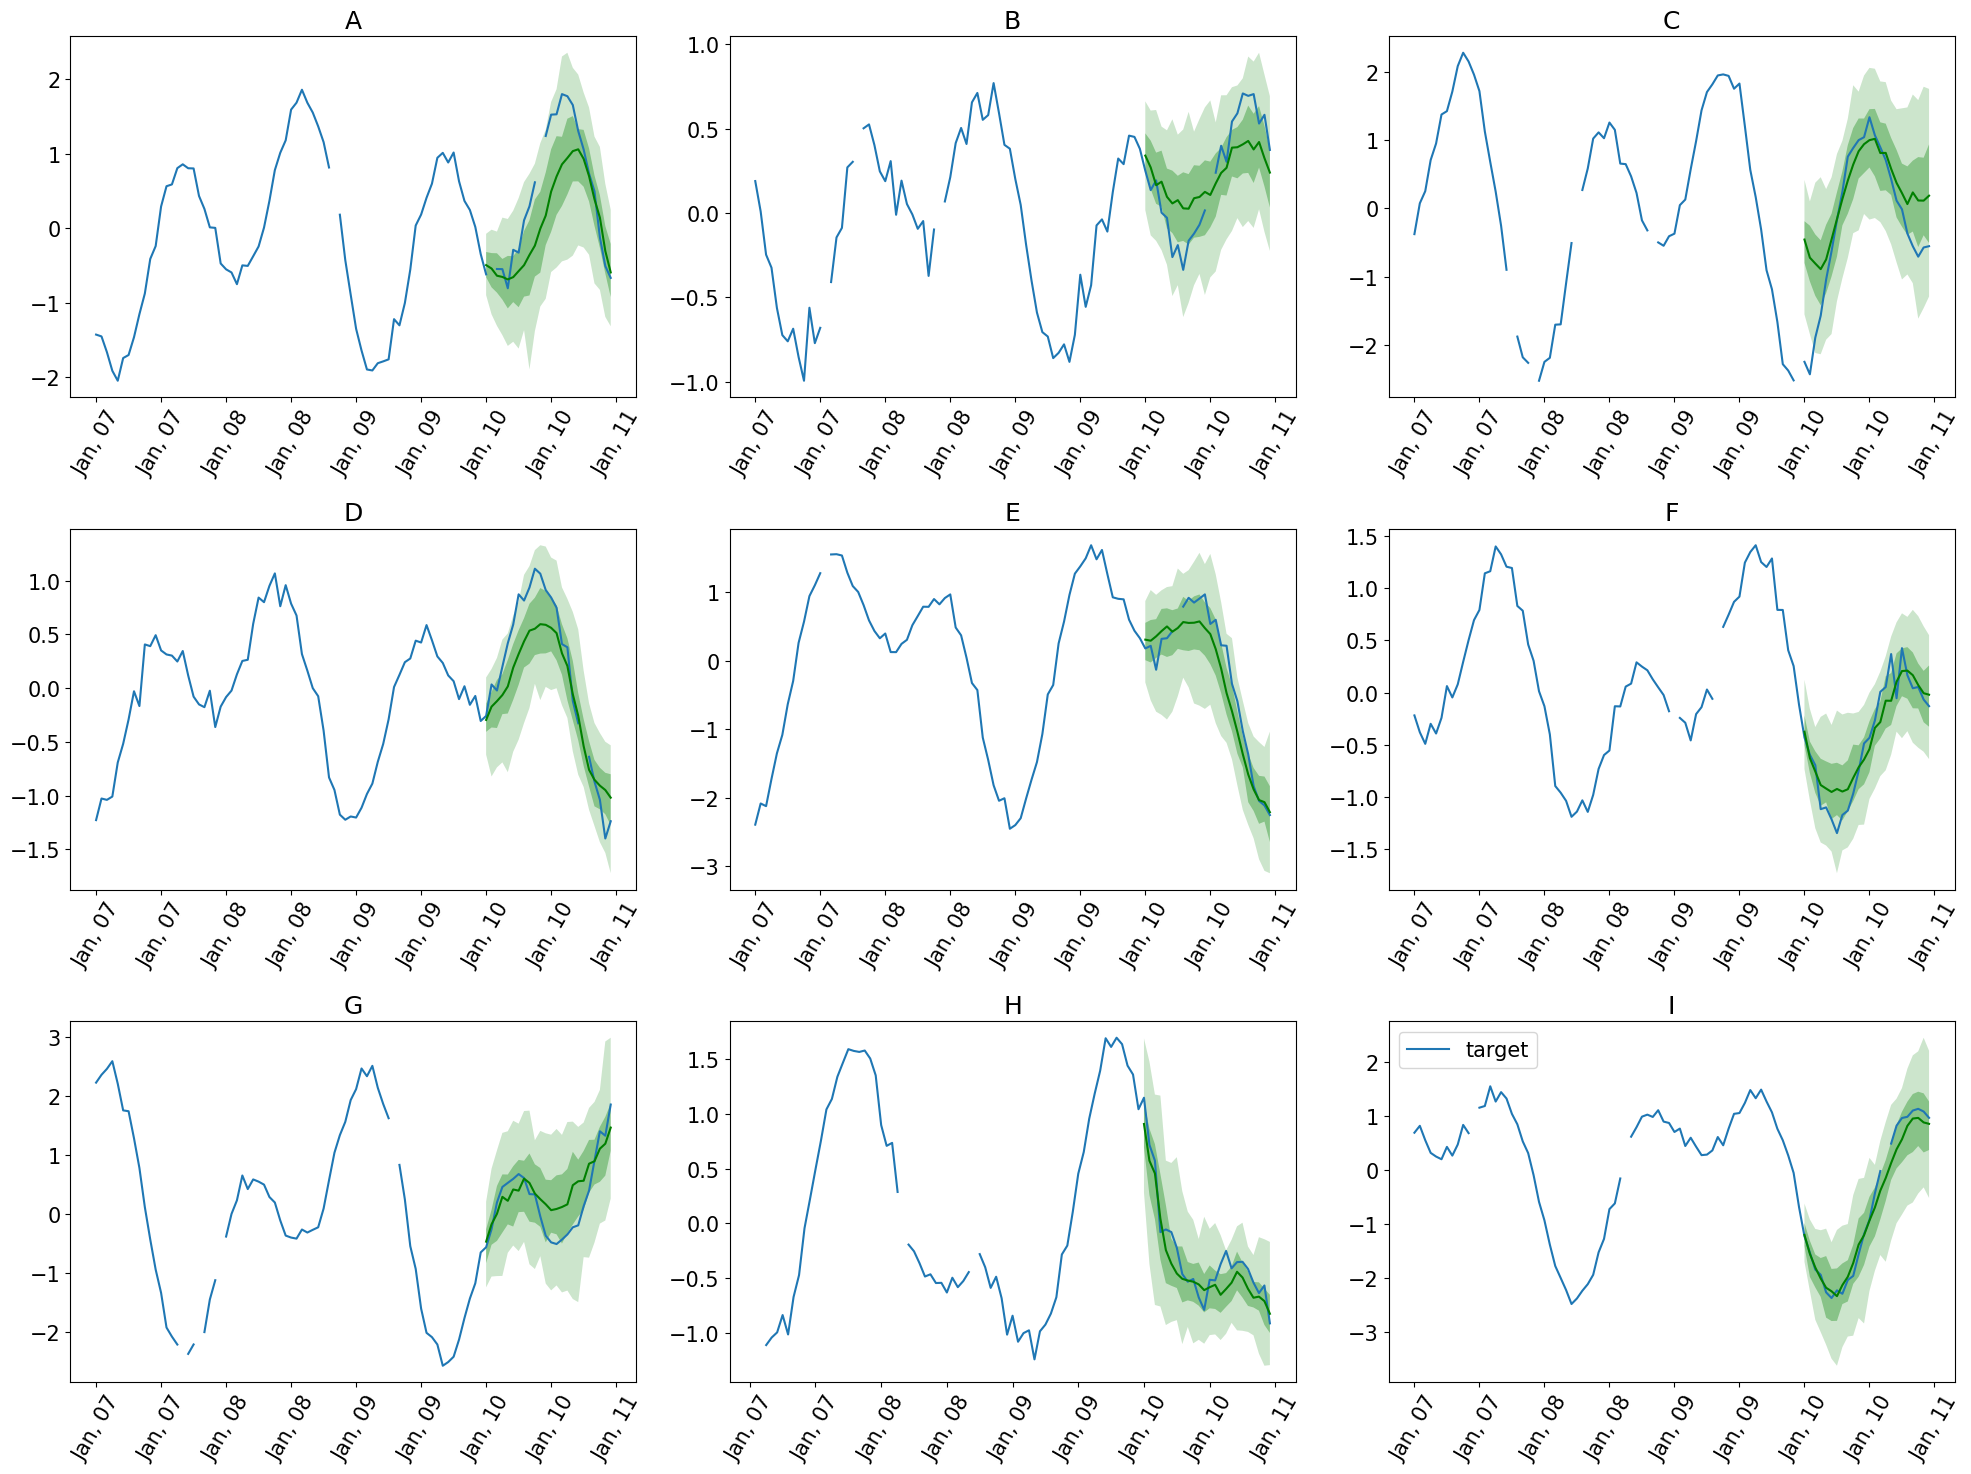

In [15]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [17]:
import pandas as pd
from gluonts.dataset.pandas import PandasDataset

url_wide = (
    "https://gist.githubusercontent.com/rsnirwan/c8c8654a98350fadd229b00167174ec4"
    "/raw/a42101c7786d4bc7695228a0f2c8cea41340e18f/ts_wide.csv"
)
df_wide = pd.read_csv(url_wide, index_col=0, parse_dates=True)
df_wide

,A,B,C,D,E,F,G,H,I,J
2021-01-01 00:00:00,-1.3378,0.1268,-0.3645,-1.0864,-2.3803,-0.2447,2.2647,-0.7917,0.7071,1.3763
2021-01-01 01:00:00,-1.6111,0.0926,-0.1364,-1.1613,-2.1421,-0.3477,2.4262,-0.9609,0.6413,1.2750
2021-01-01 02:00:00,-1.9259,-0.1420,0.1063,-1.0405,-2.1426,-0.3271,2.4434,-0.9034,0.4323,0.6767
2021-01-01 03:00:00,-1.9184,-0.4930,0.6269,-0.8531,-1.7060,-0.3088,2.4307,-0.9602,0.3193,0.5150
2021-01-01 04:00:00,-1.9168,-0.5057,0.9419,-0.7666,-1.4287,-0.4284,2.3258,-1.2504,0.3660,0.1708
...,...,...,...,...,...,...,...,...,...,...
2021-01-10 19:00:00,0.7328,0.6937,-0.3679,-0.6389,-1.3643,0.1667,0.3918,-0.4162,0.9811,1.2349
2021-01-10 20:00:00,0.4957,0.7043,-0.5553,-0.8691,-1.8283,0.0413,0.8977,-0.5412,1.0969,1.1525
2021-01-10 21:00:00,-0.1209,0.5297,-0.7084,-1.0384,-2.0439,0.0534,1.3973,-0.6366,1.1286,1.1485
2021-01-10 22:00:00,-0.5072,0.5816,-0.5735,-1.3990,-2.1105,-0.0674,1.3225,-0.5672,1.0786,1.3248


In [18]:
# Convert numerical columns to float 32 format for lag-llama
for col in df_wide.columns:
    # Check if column is not of string type
    if df_wide[col].dtype != 'object' and pd.api.types.is_string_dtype(df_wide[col]) == False:
        df_wide[col] = df_wide[col].astype('float32')

# Create a PandasDataset
ds = PandasDataset(dict(df_wide))

backtest_dataset = ds
prediction_length = 24  # Define your prediction length (e.g., 24 here since the data frequency is hourly).
num_samples = 100 # number of samples sampled from the probability distribution for each timestep
device = torch.device("cuda:0") # You can switch this to CPU or other GPUs if you'd like, depending on your environment

In [19]:
forecasts, tss = get_lag_llama_predictions(backtest_dataset, prediction_length, device, num_samples)

/tmp/ipykernel_192536/42396323.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location=device) # Uses GPU sinc

In [20]:
len(forecasts)

10

In [21]:
forecasts[0].samples.shape

(100, 24)

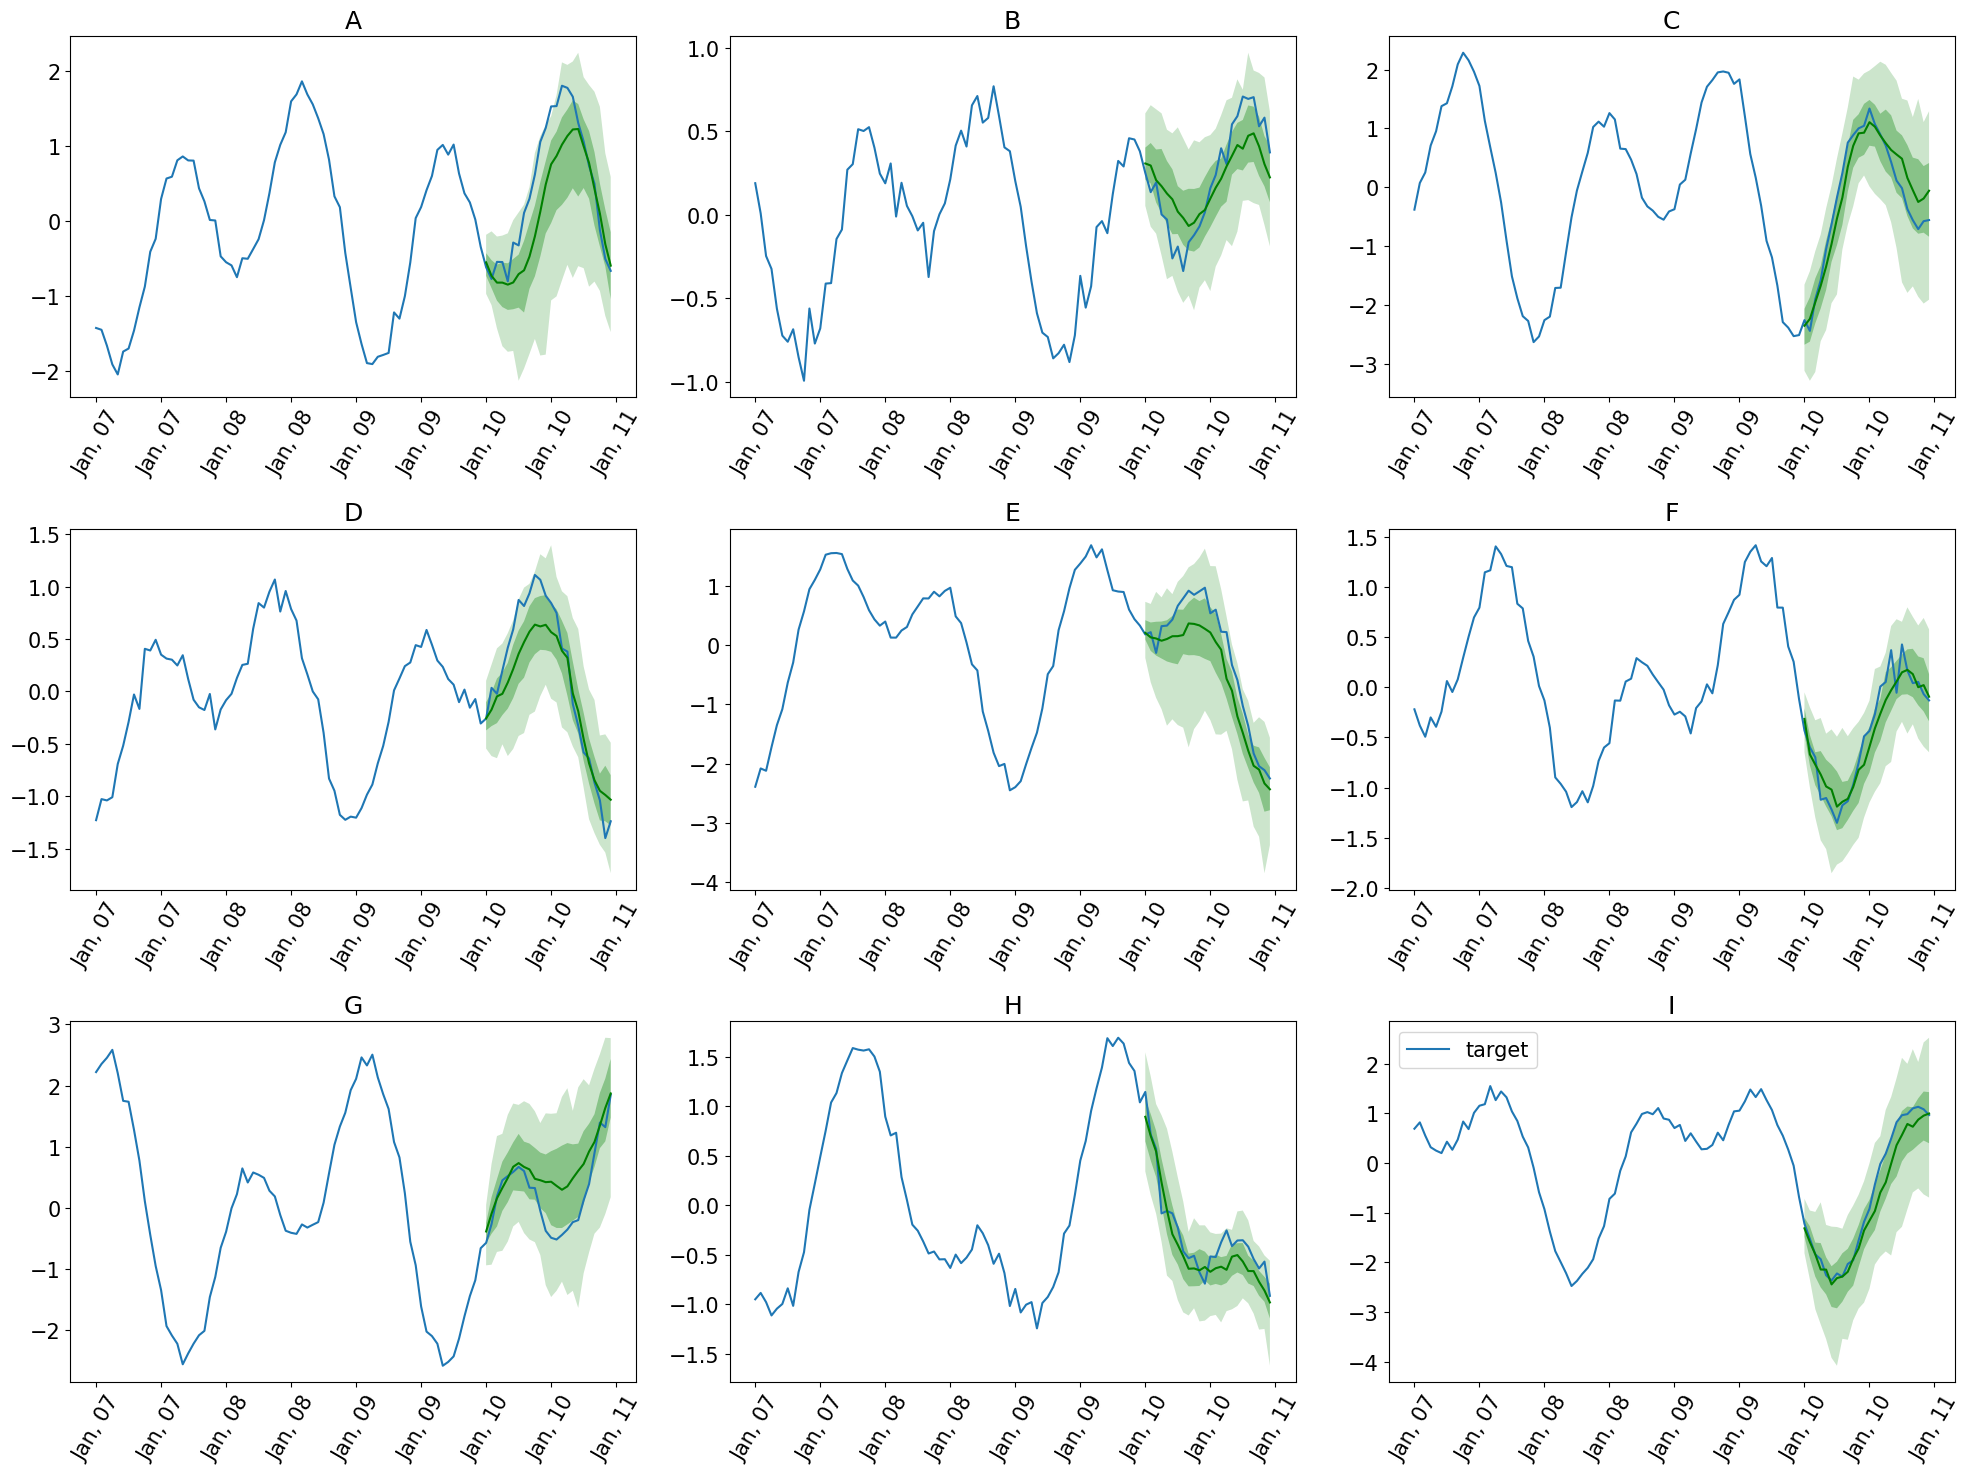

In [22]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

# TUNING CONTEXT LENGTH FOR ZERO-SHOT FORECASTING

In [25]:
df = pd.read_csv("https://gist.githubusercontent.com/dannymorris/ac176586e0236bd9278e9c81e06851a8/raw/54fd7c7520702d3dd7d4bd59c9dfbed5385af438/aus_retail.csv")
df = df.set_index('Month')

df

,Australian_Capital_Territory_Cafes__restaurants_and_catering_services,Australian_Capital_Territory_Cafes__restaurants_and_takeaway_food_services,Australian_Capital_Territory_Clothing__footwear_and_personal_accessory_retailing,Australian_Capital_Territory_Clothing_retailing,Australian_Capital_Territory_Department_stores,Australian_Capital_Territory_Electrical_and_electronic_goods_retailing,Australian_Capital_Territory_Food_retailing,Australian_Capital_Territory_Footwear_and_other_personal_accessory_retailing,Australian_Capital_Territory_Furniture__floor_coverings__houseware_and_textile_goods_retailing,Australian_Capital_Territory_Hardware__building_and_garden_supplies_retailing,...,Western_Australia_Household_goods_retailing,Western_Australia_Liquor_retailing,Western_Australia_Newspaper_and_book_retailing,Western_Australia_Other_recreational_goods_retailing,Western_Australia_Other_retailing,Western_Australia_Other_retailing_n_e_c_,Western_Australia_Other_specialised_food_retailing,Western_Australia_Pharmaceutical__cosmetic_and_toiletry_goods_retailing,Western_Australia_Supermarket_and_grocery_stores,Western_Australia_Takeaway_food_services
Month,,,,,,,,,,,,,,,,,,,,,
1982-04-01,4.4,7.6,5.9,3.7,10.3,4.4,15.5,2.2,2.7,2.6,...,50.4,12.3,9.7,6.5,42.1,11.3,13.1,14.6,96.6,10.4
1982-05-01,3.4,6.7,5.9,3.8,10.6,4.9,15.1,2.1,3.0,3.3,...,57.9,11.8,11.0,7.2,45.0,11.6,13.4,15.2,96.4,10.3
1982-06-01,3.6,7.1,5.1,3.2,9.9,4.8,15.5,2.0,2.5,2.7,...,54.4,11.3,10.7,6.6,42.5,10.9,13.5,14.5,95.6,10.4
1982-07-01,4.0,7.5,5.4,3.4,8.8,5.1,16.1,2.1,2.8,2.4,...,56.2,12.1,9.0,7.0,42.0,11.4,13.8,14.6,103.3,10.3
1982-08-01,3.6,7.3,5.0,3.1,8.8,4.6,15.8,2.0,2.8,2.7,...,55.0,12.0,9.1,6.8,42.1,10.9,13.3,15.3,96.6,10.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-01,41.7,69.2,35.0,22.1,25.6,30.0,206.1,12.9,25.9,26.6,...,441.7,122.8,38.3,39.4,376.6,139.6,87.3,159.3,974.4,178.5
2018-09-01,41.4,68.6,36.0,23.4,26.6,32.5,203.4,12.7,26.7,32.7,...,444.2,122.8,37.2,41.8,358.9,130.9,87.3,149.0,954.5,179.8
2018-10-01,41.7,70.2,36.8,24.4,29.9,32.1,214.8,12.3,28.7,37.6,...,481.1,123.5,36.6,49.0,394.2,143.7,87.3,164.8,999.1,183.2


In [26]:
metadata = {
    'prediction_length': 12,
    'freq': '1M'
}

In [27]:
from gluonts.dataset.common import ListDataset

train_data = [{"start": df.index[0], "target": df[i].values[:-metadata['prediction_length']]} for i in df.columns]
test_data = [{"start": df.index[0], "target": df[i].values} for i in df.columns]

train_ds = ListDataset(
    data_iter=train_data,
    freq=metadata['freq']
)

test_ds = ListDataset(
    data_iter=test_data,
    freq=metadata['freq']
)
device = torch.device("cuda:0") # You can switch this to CPU or other GPUs if you'd like, depending on your environment

In [28]:
forecasts_ctx_len_32, tss_ctx_len_32 = get_lag_llama_predictions(test_ds, prediction_length=metadata['prediction_length'], device=device, \
                                           context_length=32, use_rope_scaling=False, num_samples=30)
forecasts_ctx_len_32 = list(forecasts_ctx_len_32)
tss_ctx_len_32 = list(tss_ctx_len_32)

evaluator = Evaluator()
agg_metrics_ctx_len_32, ts_metrics_ctx_len_32 = evaluator(iter(tss_ctx_len_32), iter(forecasts_ctx_len_32))
print("CRPS:", agg_metrics_ctx_len_32['mean_wQuantileLoss'])

/tmp/ipykernel_192536/42396323.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location=device) # Uses GPU sinc

Running evaluation: 152it [00:00, 3991.27it/s]
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed 

CRPS: 0.0800478669732353


/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [29]:
forecasts_ctx_len_64, tss_ctx_len_64 = get_lag_llama_predictions(test_ds, prediction_length=metadata['prediction_length'], device=device, \
                                           context_length=64, use_rope_scaling=False, num_samples=30)
forecasts_ctx_len_64 = list(forecasts_ctx_len_64)
tss_ctx_len_64 = list(tss_ctx_len_64)

evaluator = Evaluator()
agg_metrics_ctx_len_64, ts_metrics_ctx_len_64 = evaluator(iter(tss_ctx_len_64), iter(forecasts_ctx_len_64))
print("CRPS:", agg_metrics_ctx_len_64['mean_wQuantileLoss'])

/tmp/ipykernel_192536/42396323.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location=device) # Uses GPU sinc

CRPS: 0.07241436145398715


/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
